# TOPIC :-Online User Behaviour Analysis — Graphical Model

## DMDW Case Study

### Step 1. imports

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sqlalchemy import create_engine
import pandas as pd
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

# association rules
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

# plotting defaults
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

# Paths
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(exist_ok=True)


### step 2 : Load dataset

In [2]:

df = pd.read_csv('ecommerce_customer_data_custom_ratios.csv')
print('Rows,Cols:', df.shape)
df.head()


Rows,Cols: (250000, 13)


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


### step 3: Quick data checks & mapping

In [3]:

print('Columns:', df.columns.tolist())
print('\nMissing values per column:\n', df.isna().sum())

# Keep original copy
df_original = df.copy()

# Auto-detect common column names and map to canonical names used in this notebook
col_map = {}
for c in ['user_id','userid','visitorid','Customer ID','customer_id']:
    if c in df.columns:
        col_map['user_id'] = c
        break
for c in ['purchase_made','purchase','is_purchase','Churn']:
    if c in df.columns:
        col_map['purchase_made'] = c
        break
for c in ['time_spent_min','time_spent','duration']:
    if c in df.columns:
        col_map['time_spent_min'] = c
        break
for c in ['pages_visited','page_views','pages']:
    if c in df.columns:
        col_map['pages_visited'] = c
        break
for c in ['clicked_ad','ad_click','clicked']:
    if c in df.columns:
        col_map['clicked_ad'] = c
        break
for c in ['category_viewed','category','Product Category','category_name']:
    if c in df.columns:
        col_map['category_viewed'] = c
        break
for c in ['Purchase Date','purchase_date','timestamp']:
    if c in df.columns:
        col_map['purchase_date'] = c
        break
for c in ['Age','age','Customer Age']:
    if c in df.columns:
        col_map['age'] = c
        break
for c in ['Gender','gender','sex']:
    if c in df.columns:
        col_map['gender'] = c
        break

print('Auto-detected mapping:', col_map)


Columns: ['Customer ID', 'Purchase Date', 'Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns', 'Customer Name', 'Age', 'Gender', 'Churn']

Missing values per column:
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64
Auto-detected mapping: {'user_id': 'Customer ID', 'purchase_made': 'Churn', 'category_viewed': 'Product Category', 'purchase_date': 'Purchase Date', 'age': 'Age', 'gender': 'Gender'}


### step 4: Feature engineering & canonical columns

In [4]:

data = df.copy()

# handle purchase_date -> extract time features
if 'purchase_date' in col_map:
    pdcol = col_map['purchase_date']
    data[pdcol] = pd.to_datetime(data[pdcol], errors='coerce')
    data['Purchase_Year'] = data[pdcol].dt.year
    data['Purchase_Month'] = data[pdcol].dt.month
    data['Purchase_DayOfWeek'] = data[pdcol].dt.dayofweek
    data['Purchase_Hour'] = data[pdcol].dt.hour
    # drop original to avoid leakage
    data = data.drop(columns=[pdcol])
else:
    # create synthetic time features if not present
    data['Purchase_Year'] = np.nan
    data['Purchase_Month'] = np.nan
    data['Purchase_DayOfWeek'] = np.nan
    data['Purchase_Hour'] = np.nan

# canonical basic columns with fallbacks
if 'user_id' in col_map:
    data = data.rename(columns={col_map['user_id']:'user_id'})
else:
    data['user_id'] = range(1, len(data)+1)

if 'purchase_made' in col_map:
    data = data.rename(columns={col_map['purchase_made']:'purchase_made'})
else:
    # if no purchase flag, try to infer from 'Total' or 'amount' columns
    found = False
    for c in ['Total Purchase Amount','total','amount','revenue']:
        if c in data.columns:
            data['purchase_made'] = (data[c].fillna(0) > 0).astype(int)
            found = True
            break
    if not found:
        data['purchase_made'] = 0

# pages visited
if 'pages_visited' in col_map:
    data = data.rename(columns={col_map['pages_visited']:'pages_visited'})
else:
    data['pages_visited'] = data.get('pages_visited', np.random.randint(1,10,size=len(data)))

# time spent
if 'time_spent_min' in col_map:
    data = data.rename(columns={col_map['time_spent_min']:'time_spent_min'})
else:
    data['time_spent_min'] = data.get('time_spent_min', np.random.randint(1,60,size=len(data)))

# clicked ad
if 'clicked_ad' in col_map:
    data = data.rename(columns={col_map['clicked_ad']:'clicked_ad'})
else:
    data['clicked_ad'] = data.get('clicked_ad', 0)

# category
if 'category_viewed' in col_map:
    data = data.rename(columns={col_map['category_viewed']:'category_viewed'})
else:
    data['category_viewed'] = data.get('category_viewed', 'Unknown')

# age and gender
if 'age' in col_map:
    data = data.rename(columns={col_map['age']:'age'})
else:
    data['age'] = data.get('age', np.random.randint(18,60,size=len(data)))

if 'gender' in col_map:
    data = data.rename(columns={col_map['gender']:'gender'})
else:
    data['gender'] = data.get('gender', np.random.choice(['Male','Female'], size=len(data)))

# discretize age & time
data['age_group'] = pd.cut(data['age'], bins=[17,25,35,50,100], labels=['Youth','Adult','Middle','Senior'])
data['time_group'] = pd.cut(data['time_spent_min'], bins=[0,10,20,40,1000], labels=['Short','Medium','Long','VeryLong'])

print('Feature engineering completed. Sample:')
data.head()


Feature engineering completed. Sample:


,user_id,category_viewed,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,age,...,purchase_made,Purchase_Year,Purchase_Month,Purchase_DayOfWeek,Purchase_Hour,pages_visited,time_spent_min,clicked_ad,age_group,time_group
0,46251,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,...,0,2020,9,1,9,3,9,0,Middle,Short
1,46251,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,...,0,2022,3,5,12,2,52,0,Middle,VeryLong
2,46251,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,...,0,2022,5,0,18,7,51,0,Middle,VeryLong
3,46251,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,...,0,2020,11,3,13,2,8,0,Middle,Short
4,13593,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,...,1,2020,11,4,17,9,36,0,Middle,Long


### Step 5: Exploratory Data Analysis (EDA)


Overall purchase rate: 0.199496


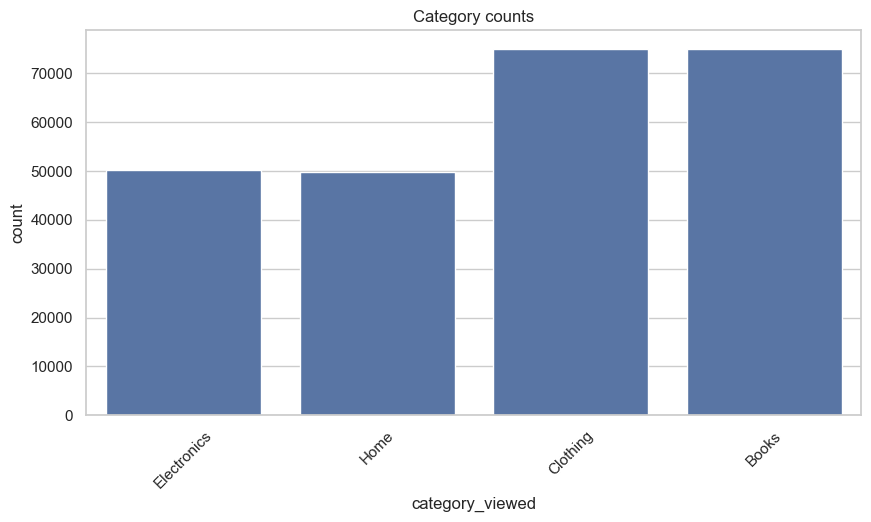

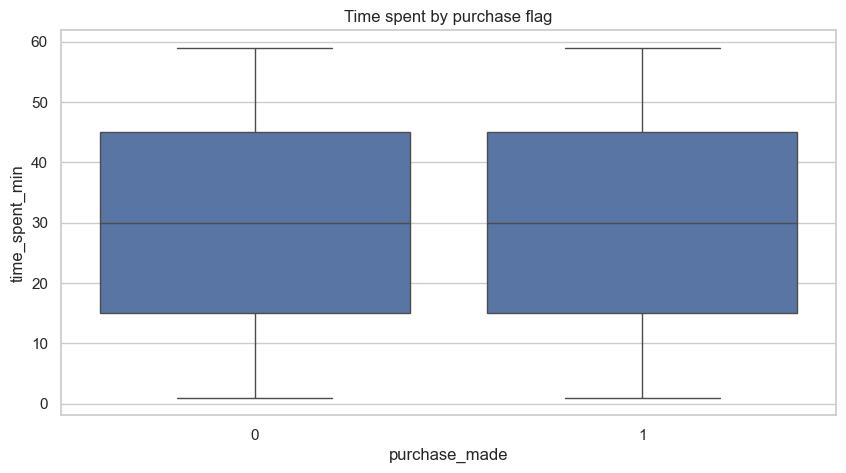

C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


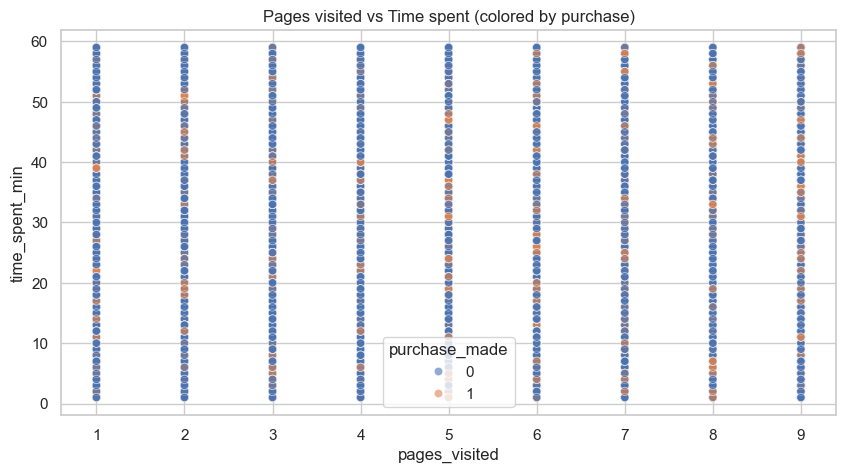

In [5]:
print('Overall purchase rate:', data['purchase_made'].mean())
plt.figure()
sns.countplot(x='category_viewed', data=data)
plt.title('Category counts')
plt.xticks(rotation=45)
plt.show()

plt.figure()
sns.boxplot(x='purchase_made', y='time_spent_min', data=data)
plt.title('Time spent by purchase flag')
plt.show()

plt.figure()
sns.scatterplot(x='pages_visited', y='time_spent_min', hue='purchase_made', data=data, alpha=0.6)
plt.title('Pages visited vs Time spent (colored by purchase)')
plt.show()


### Step 6: Association rules 


In [6]:
# Build a basket: one-hot encode category + clicked_ad + purchase_made
# ------------------------------
# Step 1: Build the basket
# ------------------------------

# Optionally, select top categories to avoid too sparse data
top_cats = data['category_viewed'].value_counts().nlargest(10).index
basket = pd.get_dummies(data[data['category_viewed'].isin(top_cats)][['category_viewed']])

# Add clicked_ad and purchase_made if needed
basket['clicked_ad'] = data['clicked_ad'].astype(int)
basket['purchase_made'] = data['purchase_made'].astype(int)

print("Basket shape:", basket.shape)
print("Sample of basket:\n", basket.head())

# ------------------------------
# Step 2: Run Apriori
# ------------------------------
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)  # lower support to catch sparse items
print("Frequent itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# ------------------------------
# Step 3: Generate association rules
# ------------------------------
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)  # lower threshold
print("\nTop rules:")
print(rules.sort_values(['confidence','lift'], ascending=[False,False]).head(10))



Basket shape: (250000, 6)
Sample of basket:
    category_viewed_Books  category_viewed_Clothing  \
0                  False                     False   
1                  False                     False   
2                  False                     False   
3                  False                      True   
4                  False                     False   

   category_viewed_Electronics  category_viewed_Home  clicked_ad  \
0                         True                 False           0   
1                        False                  True           0   
2                        False                  True           0   
3                        False                 False           0   
4                        False                  True           0   

   purchase_made  
0              0  
1              0  
2              0  
3              0  
4              1  


C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent itemsets:
    support                                      itemsets
1  0.300208                    (category_viewed_Clothing)
0  0.299648                       (category_viewed_Books)
2   0.20074                 (category_viewed_Electronics)
4  0.199496                               (purchase_made)
3  0.199404                        (category_viewed_Home)
5  0.059704        (category_viewed_Books, purchase_made)
6  0.059592     (category_viewed_Clothing, purchase_made)
8  0.040284         (category_viewed_Home, purchase_made)
7  0.039916  (category_viewed_Electronics, purchase_made)

Top rules:
                     antecedents                    consequents  \
1                (purchase_made)        (category_viewed_Books)   
3                (purchase_made)     (category_viewed_Clothing)   
6         (category_viewed_Home)                (purchase_made)   
7                (purchase_made)         (category_viewed_Home)   
5                (purchase_made)  (category_viewed_Ele

### Step 7: Build and visualize a graphical model (network)


Association-rule graph: nodes = 5 edges = 8


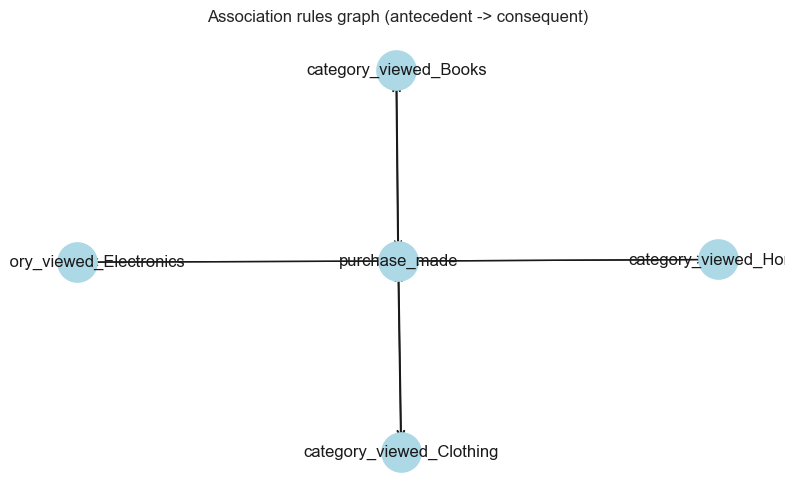

In [7]:
#  Build and plot association-rule graph
if not rules.empty:
    G_rules = nx.DiGraph()
    for _, row in rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        conf = row['confidence']
        for a in antecedents:
            for c in consequents:
                G_rules.add_edge(str(a), str(c), weight=float(conf))

    print('Association-rule graph: nodes =', G_rules.number_of_nodes(), 'edges =', G_rules.number_of_edges())

    plt.figure(figsize=(10,6))
    pos = nx.spring_layout(G_rules, k=0.8, seed=42)  # fixed seed for reproducibility
    edge_weights = [d['weight']*5 for (u,v,d) in G_rules.edges(data=True)]  # scale edges
    nx.draw_networkx_nodes(G_rules, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(G_rules, pos)
    nx.draw_networkx_edges(G_rules, pos, arrowstyle='->', arrowsize=12, width=edge_weights)
    plt.title('Association rules graph (antecedent -> consequent)')
    plt.axis('off')
    plt.show()
else:
    print("No association rules found!")


### Step 5: Optional: Bipartite User-Category graph


Bipartite graph nodes: 204 edges: 628


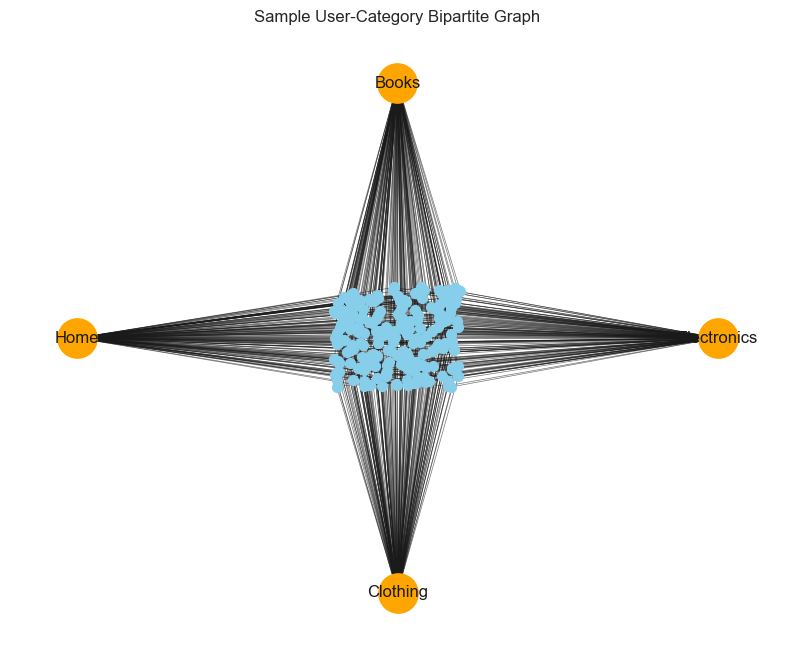

In [8]:


B = nx.Graph()
sample_users = data['user_id'].sample(n=min(200, len(data)), random_state=42)
for uid in sample_users:
    user_rows = data[data['user_id'] == uid]
    cats = user_rows['category_viewed'].unique()
    user_node = f'U{uid}'
    B.add_node(user_node, bipartite=0)
    for c in cats:
        if c in top_cats:  # only include top categories
            cat_node = f'C_{c}'
            B.add_node(cat_node, bipartite=1)
            B.add_edge(user_node, cat_node)

print('Bipartite graph nodes:', B.number_of_nodes(), 'edges:', B.number_of_edges())

# Draw bipartite graph
user_nodes = [n for n,d in B.nodes(data=True) if d['bipartite']==0]
cat_nodes = [n for n,d in B.nodes(data=True) if d['bipartite']==1]
pos = dict()
if len(cat_nodes) > 0:
    pos_cat = nx.circular_layout(cat_nodes)
    pos.update(pos_cat)
pos_user = {u: (np.random.uniform(-0.2,0.2), np.random.uniform(-0.2,0.2)) for u in user_nodes}
pos.update(pos_user)

plt.figure(figsize=(10,8))
nx.draw_networkx_nodes(B, pos, nodelist=cat_nodes, node_size=800, node_color='orange', label='Category')
nx.draw_networkx_nodes(B, pos, nodelist=user_nodes, node_size=50, node_color='skyblue', label='User')
nx.draw_networkx_edges(B, pos, width=0.5, alpha=0.6)
labels = {n:n.replace('C_','') for n in cat_nodes}
nx.draw_networkx_labels(B, {k:v for k,v in pos.items() if k in cat_nodes}, labels)
plt.title('Sample User-Category Bipartite Graph')
plt.axis('off')
plt.show()

### Step 8: Prepare features & train a simple classifier (Module 3)


Decision Tree trained. Test accuracy: 0.68494
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     40025
           1       0.21      0.21      0.21      9975

    accuracy                           0.68     50000
   macro avg       0.51      0.51      0.51     50000
weighted avg       0.68      0.68      0.68     50000



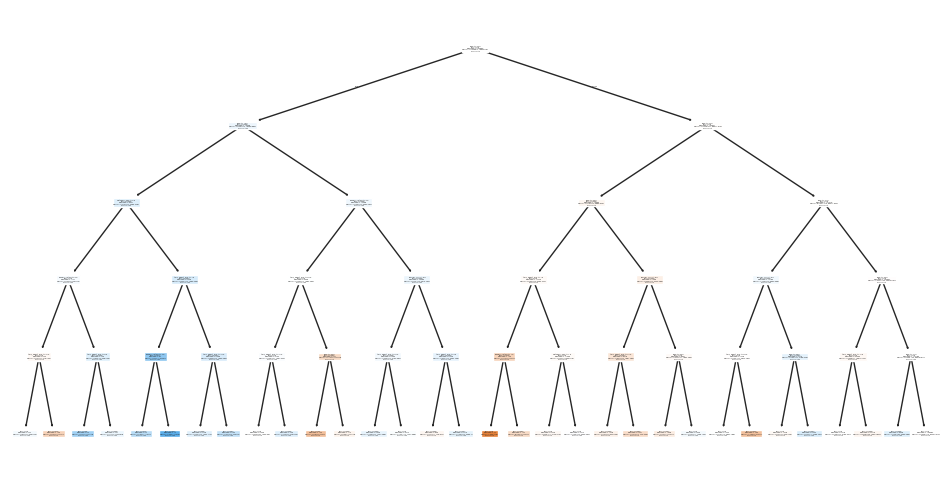

['models\\le_gender.joblib']

In [9]:
# Encode categorical features
le_cat = LabelEncoder()
data['category_enc'] = le_cat.fit_transform(data['category_viewed'].astype(str))
le_gender = LabelEncoder()
data['gender_enc'] = le_gender.fit_transform(data['gender'].astype(str))

feature_cols = ['age','gender_enc','time_spent_min','pages_visited','clicked_ad','category_enc']
feature_cols = [c for c in feature_cols if c in data.columns]
X = data[feature_cols].fillna(0)
y = data['purchase_made'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if y.nunique()>1 else None)

# Train Decision Tree for interpretability
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)

print('Decision Tree trained. Test accuracy:', dt.score(X_test, y_test))
print(classification_report(y_test, dt.predict(X_test), zero_division=0))

plt.figure(figsize=(12,6))
plot_tree(dt, feature_names=feature_cols, class_names=['no','yes'], filled=True)
plt.show()

joblib.dump(dt, MODELS_DIR/'dt_purchase_graphical.joblib')
joblib.dump(le_cat, MODELS_DIR/'le_cat.joblib')
joblib.dump(le_gender, MODELS_DIR/'le_gender.joblib')


### Step 9: Clustering (k-Means) & Outlier Detection (LOF) - Module 4

C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


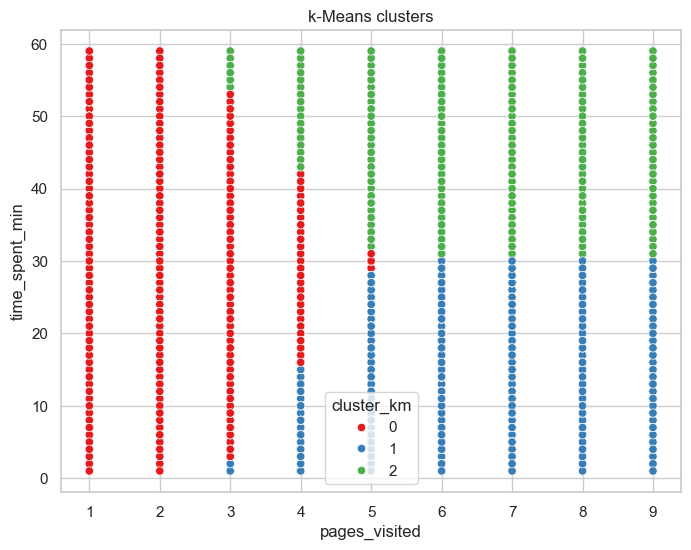

Outliers detected: 0


C:\Users\biswa\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


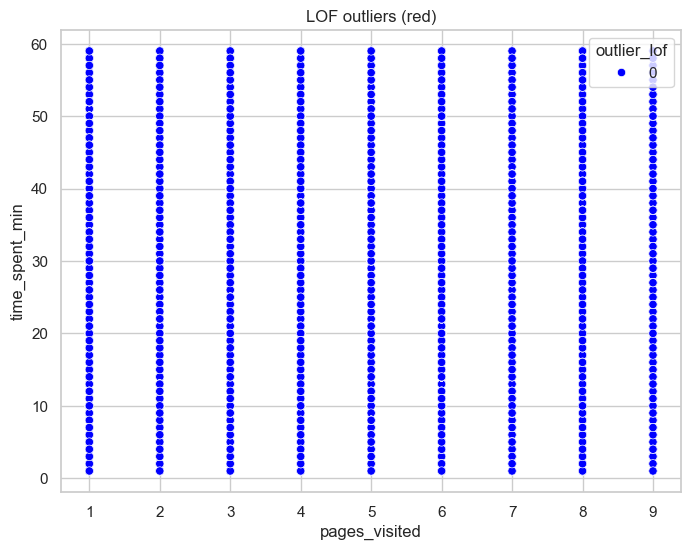

['models\\scaler_km.joblib']

In [10]:

from sklearn.preprocessing import StandardScaler
Xc = data[['time_spent_min','pages_visited']].fillna(0)
scaler = StandardScaler()
Xc_s = scaler.fit_transform(Xc)

# k-means
km = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = km.fit_predict(Xc_s)
data['cluster_km'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x='pages_visited', y='time_spent_min', hue='cluster_km', data=data, palette='Set1')
plt.title('k-Means clusters')
plt.show()

# LOF for outlier detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_labels = lof.fit_predict(Xc_s)
data['outlier_lof'] = (lof_labels == -1).astype(int)
print('Outliers detected:', data['outlier_lof'].sum())

plt.figure(figsize=(8,6))
sns.scatterplot(x='pages_visited', y='time_spent_min', hue='outlier_lof', data=data, palette={0:'blue',1:'red'})
plt.title('LOF outliers (red)')
plt.show()

joblib.dump(km, MODELS_DIR/'kmeans_behavior.joblib')
joblib.dump(scaler, MODELS_DIR/'scaler_km.joblib')


In [11]:
# Cell 10: Data Warehouse (Module 5) - create simple star schema in SQLite
engine = create_engine('sqlite:///online_user_graph_dw.db', echo=False)

# dim_user
dim_user = data[['user_id','age','gender','age_group','cluster_km']].drop_duplicates().rename(columns={'user_id':'user_id'})
dim_user.to_sql('dim_user', engine, if_exists='replace', index=False)

# dim_time
dim_time = pd.DataFrame({'time_id':[1,2,3,4], 'time_label':['Morning','Afternoon','Evening','Night']})
dim_time.to_sql('dim_time', engine, if_exists='replace', index=False)

# dim_category
dim_category = pd.DataFrame({'category_id': range(len(le_cat.classes_)), 'category_name': le_cat.classes_})
dim_category.to_sql('dim_category', engine, if_exists='replace', index=False)

# fact_behavior
fact = data[['user_id','pages_visited','time_spent_min','clicked_ad','purchase_made','category_enc']].rename(columns={'category_enc':'category_id'})
fact['time_id'] = np.random.choice(dim_time['time_id'], size=len(fact))
fact.to_sql('fact_behavior', engine, if_exists='replace', index=False)

print('DW created: online_user_graph_dw.db with dim_user, dim_time, dim_category, fact_behavior')

# OLAP queries
q1 = pd.read_sql('''
SELECT cluster_km as cluster, AVG(pages_visited) as avg_pages, AVG(time_spent_min) as avg_time, AVG(purchase_made) as purchase_rate
FROM fact_behavior f JOIN dim_user u ON f.user_id = u.user_id
GROUP BY cluster_km
''', engine)
print('OLAP: avg pages/time/purchase by cluster')
q1

q2 = pd.read_sql('''
SELECT c.category_name, AVG(f.purchase_made) as purchase_rate, COUNT(*) as views
FROM fact_behavior f JOIN dim_category c ON f.category_id = c.category_id
GROUP BY c.category_name
ORDER BY purchase_rate DESC
''', engine)
print('OLAP: purchase rate by category')
q2


DW created: online_user_graph_dw.db with dim_user, dim_time, dim_category, fact_behavior
OLAP: avg pages/time/purchase by cluster
OLAP: purchase rate by category


,category_name,purchase_rate,views
0,Home,0.202022,49851
1,Books,0.199247,74912
2,Electronics,0.198844,50185
3,Clothing,0.198502,75052


In [12]:
# Cell 11: Save artifacts & final notes
print('Models and encoders saved in models/:')
for f in MODELS_DIR.iterdir():
    print('-', f.name)

print('\nNotebook complete. Include the following in your report:')
print('- Dataset description and preprocessing (Module 1)')
print('- Association rules and association-graph (Module 2)')
print('- Classification model and evaluation (Module 3)')
print('- Clustering & outlier detection (Module 4)')
print('- Data Warehouse star schema and OLAP outputs (Module 5)')


Models and encoders saved in models/:
- dt_purchase_graphical.joblib
- kmeans_behavior.joblib
- le_cat.joblib
- le_gender.joblib
- scaler_km.joblib

Notebook complete. Include the following in your report:
- Dataset description and preprocessing (Module 1)
- Association rules and association-graph (Module 2)
- Classification model and evaluation (Module 3)
- Clustering & outlier detection (Module 4)
- Data Warehouse star schema and OLAP outputs (Module 5)


###  Exploratory Data Analysis (EDA) Plots 

Purchase modes identified: ['Online' 'Offline' 'Other']


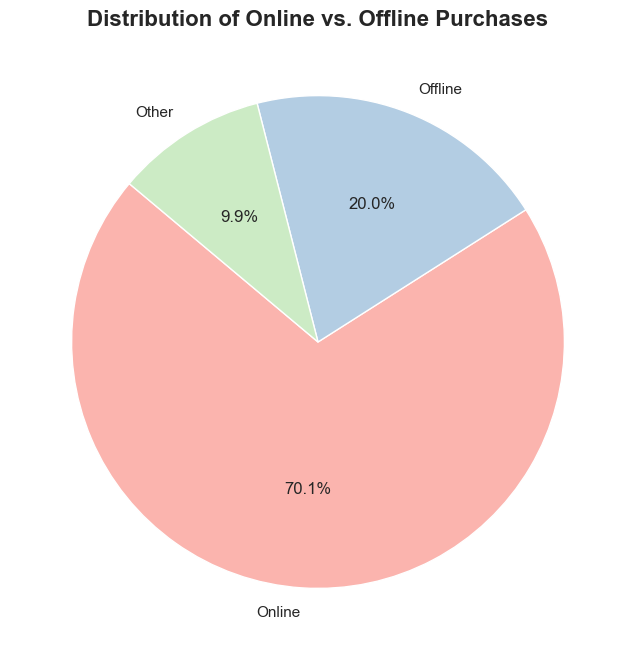

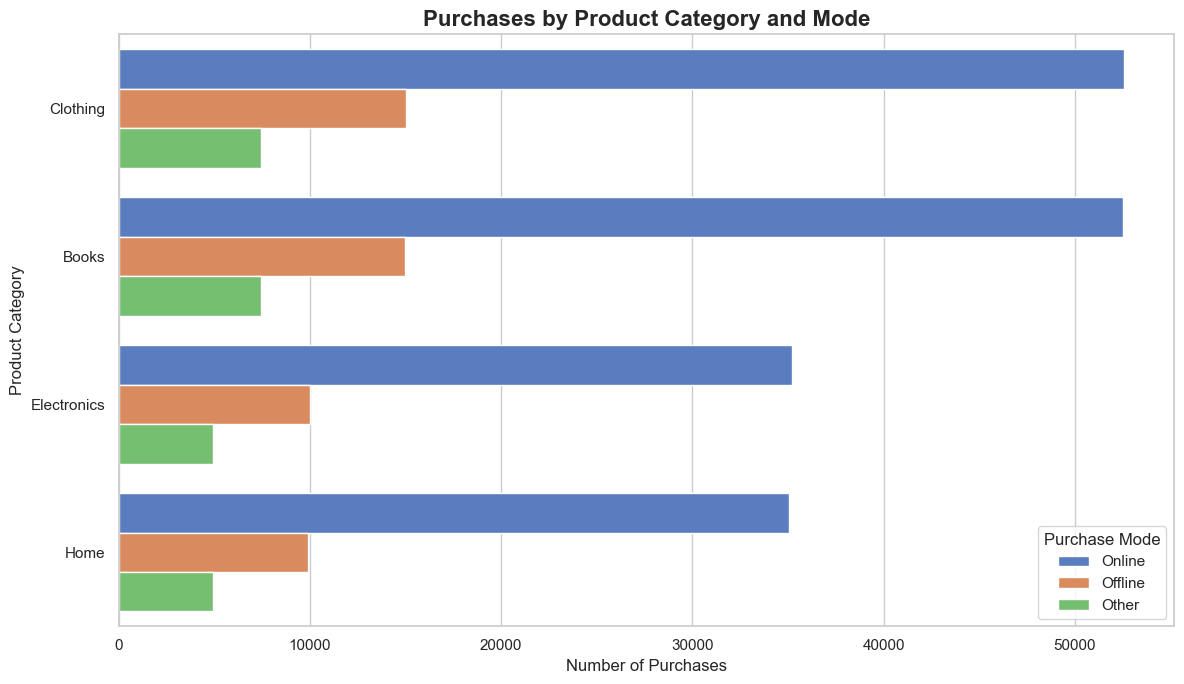

C:\Users\biswa\AppData\Local\Temp\ipykernel_11044\2176080868.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='PurchaseMode', y='Total Purchase Amount', palette='Set2')


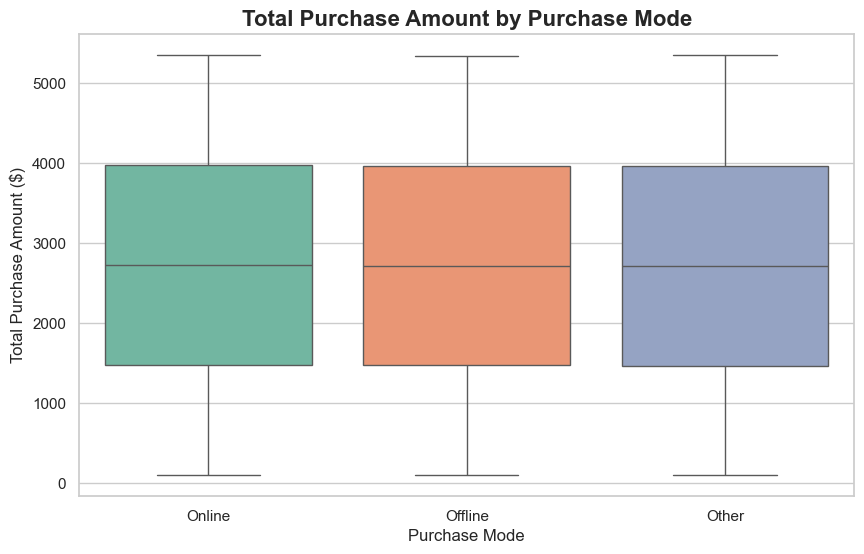

C:\Users\biswa\AppData\Local\Temp\ipykernel_11044\2176080868.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=churn_rate, x='PurchaseMode', y='Churn Rate', palette='viridis')


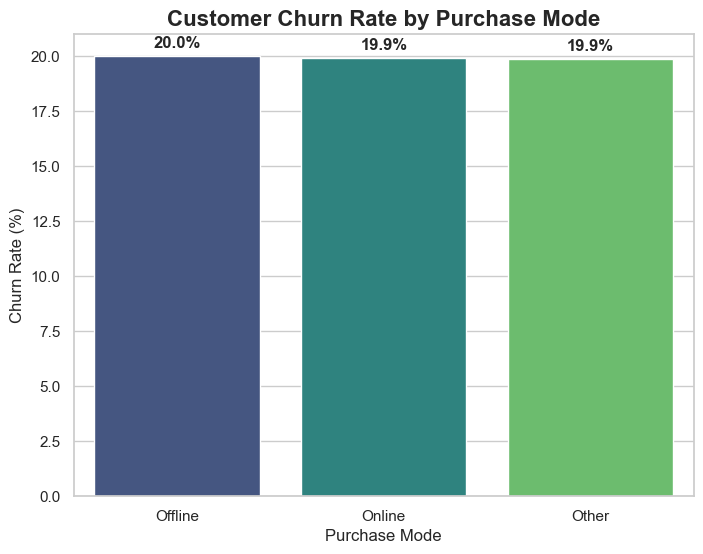

In [13]:
# Set plot style
sns.set_theme(style="whitegrid")

def map_purchase_mode(payment_method):
    if payment_method == 'Cash':
        return 'Offline'
    elif payment_method in ['Credit Card', 'PayPal']:
        return 'Online'
    else:
        return 'Other' # This will capture 'Crypto'

# Ensure the 'df' variable is your loaded DataFrame
df_plot = df.copy()
df_plot['PurchaseMode'] = df_plot['Payment Method'].apply(map_purchase_mode)
df_plot['Returns'] = df_plot['Returns'].fillna(0) # Clean returns as in your notebook

print(f"Purchase modes identified: {df_plot['PurchaseMode'].unique()}")

# --- Plot 1: Overall Purchase Mode Distribution (Pie Chart) ---
plt.figure(figsize=(8, 8))
mode_counts = df_plot['PurchaseMode'].value_counts()
plt.pie(mode_counts, labels=mode_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Pastel1'))
plt.title('Distribution of Online vs. Offline Purchases', fontsize=16, fontweight='bold')
plt.savefig('plot1_purchase_mode_distribution.png')
plt.show()

# --- Plot 2: Purchase Mode by Product Category (Bar Chart) ---
plt.figure(figsize=(12, 7))
sns.countplot(data=df_plot, y='Product Category', hue='PurchaseMode', order=df_plot['Product Category'].value_counts().index, palette='muted')
plt.title('Purchases by Product Category and Mode', fontsize=16, fontweight='bold')
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.legend(title='Purchase Mode')
plt.tight_layout()
plt.savefig('plot2_purchases_by_category_and_mode.png')
plt.show()

# --- Plot 3: Purchase Amount by Purchase Mode (Box Plot) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='PurchaseMode', y='Total Purchase Amount', palette='Set2')
plt.title('Total Purchase Amount by Purchase Mode', fontsize=16, fontweight='bold')
plt.xlabel('Purchase Mode', fontsize=12)
plt.ylabel('Total Purchase Amount ($)', fontsize=12)
plt.savefig('plot3_amount_by_mode.png')
plt.show()

# --- Plot 4: Churn Rate by Purchase Mode ---
# Calculate churn rate (mean of the 'Churn' column)
churn_rate = df_plot.groupby('PurchaseMode')['Churn'].mean().reset_index()
churn_rate['Churn Rate'] = churn_rate['Churn'] * 100  # Convert to percentage

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=churn_rate, x='PurchaseMode', y='Churn Rate', palette='viridis')
plt.title('Customer Churn Rate by Purchase Mode', fontsize=16, fontweight='bold')
plt.xlabel('Purchase Mode', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)

# Add percentage labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontweight='bold')
                
plt.savefig('plot4_churn_by_mode.png')
plt.show()